In [1]:
from matplotlib import pyplot as plt

import os
os.chdir('/engram/nklab/hossein/recurrent_models/transformer_brain_encoder/')
!pwd

import numpy as np

import h5py

from PIL import Image
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
from torchvision import transforms

from sklearn.decomposition import IncrementalPCA, PCA
import os
from pathlib import Path

#data_dir = './algonauts_2023_challenge_data'

device = 'cuda:0' #@param ['cpu', 'cuda'] {allow-input: true}
device = torch.device(device)

nsd_stimuli_dir = '/engram/nklab/datasets/natural_scene_dataset/nsddata_stimuli/stimuli/nsd/'




# filename = nsd_stimuli_dir + 'nsd_stimuli.hdf5'

# with h5py.File(filename, "r") as f:
#     # Print all root level object names (aka keys) 
#     # these can be group or dataset names 
#     print("Keys: %s" % f.keys())
#     # get first object name/key; may or may NOT be a group
#     a_group_key = list(f.keys())[0]

#     # get the object type for a_group_key: usually group or dataset
#     print(type(f[a_group_key])) 

#     # If a_group_key is a group name, 
#     # this gets the object names in the group and returns as a list
#     data = list(f[a_group_key])

#     # If a_group_key is a dataset name, 
#     # this gets the dataset values and returns as a list
#     data = list(f[a_group_key])
#     # preferred methods to get dataset values:
#     ds_obj = f[a_group_key]      # returns as a h5py dataset object
#     ds_arr = f[a_group_key][()]  # returns as a numpy array
    
    
# print(ds_arr.shape)

# transform = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.Resize((425,425)), # resize the images to 224x24 pixels
#     transforms.ToTensor(), # convert the images to a PyTorch tensor
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalize the images color channels
# ])


/engram/nklab/hossein/recurrent_models/transformer_brain_encoder


## DINO

In [3]:
arch = 'dinov2_vitb14'
model = torch.hub.load('facebookresearch/dinov2', arch).to(device)

Using cache found in /home/ha2366/.cache/torch/hub/facebookresearch_dinov2_main


In [4]:
import numpy as np
import torch.nn.functional as F

patch_size = 14

feat_out = {}
def hook_fn_forward_qkv(module, input, output):
    feat_out["qkv"] = output

# #for i in range(1,13):
model._modules["blocks"][-1]._modules["attn"]._modules["qkv"].register_forward_hook(hook_fn_forward_qkv)

def aff_features(img):

    size_im = (
        img.shape[0],
        img.shape[1],
        int(np.ceil(img.shape[2] / patch_size) * patch_size),
        int(np.ceil(img.shape[3] / patch_size) * patch_size),
    )
    paded = torch.zeros(size_im).to(device)
    paded[:,:, : img.shape[2], : img.shape[3]] = img
    img = paded

    # Size for transformers
    h_featmap = img.shape[-2] // patch_size
    w_featmap = img.shape[-1] // patch_size


    model._modules["blocks"][-10]._modules["attn"]._modules["qkv"].register_forward_hook(hook_fn_forward_qkv)

    which_features = 'q'

    with torch.no_grad():
        # Forward pass in the model
        outputs = model.get_intermediate_layers(img)

        # Scaling factor
        scales = [patch_size, patch_size]

        # Dimensions
        nb_im = img.shape[0] #Batch size
        nh = 12 #Number of heads
        nb_tokens = h_featmap*w_featmap + 1

        # Extract the qkv features of the last attention layer
        qkv = feat_out["qkv"].reshape(nb_im, nb_tokens, 3, nh, -1 // nh).permute(2, 0, 3, 1, 4)

        q, k, v = qkv[0], qkv[1], qkv[2]
        k = k.transpose(1, 2).reshape(nb_im, nb_tokens, -1)
        q = q.transpose(1, 2).reshape(nb_im, nb_tokens, -1)
        v = v.transpose(1, 2).reshape(nb_im, nb_tokens, -1)

        # Modality selection
        if which_features == "k":
            feats = k
        elif which_features == "q":
            feats = q
        elif which_features == "v":
            feats = v

        cls_token = feats[0,0:1,:].cpu().numpy() 
        
    #print(feats.flatten(1).dtype)
    return feats.flatten(1).cpu().numpy() 

    #return cls_token[0]

def extract_dino_features(dataloader):

    features = []
    for _, d in tqdm(enumerate(dataloader), total=len(dataloader)):
        # Extract features
        ft = aff_features(d.to(device))
        # Flatten the features
        features.append(ft)
    return np.vstack(features)

## AlexNet

In [2]:
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names

arch = 'alexnet'

model = torch.hub.load('pytorch/vision:v0.10.0', arch)
model.to(device) # send the model to the chosen device ('cpu' or 'cuda')
model.eval() # set the model to evaluation mode, since you are not training it

train_nodes, _ = get_graph_node_names(model)
print(train_nodes)

#feature_type =  ["features.2"] # "features.2" #"layer2.0.conv1" # #@param ["features.2", "features.5", "features.7", "features.9", "features.12", "classifier.2", "classifier.5", "classifier.6"] {allow-input: true}
#'features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 
feature_type =  ['features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'avgpool', 'flatten', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6']
#feature_type =  ['features.10', 'features.11', 'features.12', 'avgpool', 'flatten', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6']

feature_extractor = create_feature_extractor(model, return_nodes=feature_type)

def extract_alexnet_features(dataloader):

    features = []
    for _, d in tqdm(enumerate(dataloader), total=len(dataloader)):
        # Extract features
        ft = feature_extractor(d.to(device))
        ft = torch.hstack([torch.flatten(l, start_dim=1) for l in ft.values()])
        # Flatten the features
        features.append(ft.detach().cpu().numpy())
    return np.vstack(features)



Using cache found in /home/ha2366/.cache/torch/hub/pytorch_vision_v0.10.0


['x', 'features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'avgpool', 'flatten', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6']


In [3]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [4]:
def fit_pca(feature_extractor, dataloader):

    # Define PCA parameters
    pca = IncrementalPCA(n_components=768, batch_size=1536)

    # Fit PCA to batch
    for _, d in tqdm(enumerate(dataloader), total=len(dataloader)):
        # Extract features
        ft = feature_extractor(d)
        # Flatten the features
        ft = torch.hstack([torch.flatten(l, start_dim=1) for l in ft.values()])
        # Fit PCA to batch
        pca.partial_fit(ft.detach().cpu().numpy())
    return pca


def extract_features(feature_extractor, dataloader, pca):

    features = []
    for _, d in tqdm(enumerate(dataloader), total=len(dataloader)):
        # Extract features
        ft = feature_extractor(d)
        # Flatten the features
        ft = torch.hstack([torch.flatten(l, start_dim=1) for l in ft.values()])
        # Apply PCA transform
        ft = pca.transform(ft.cpu().detach().numpy())
        features.append(ft)
    return np.vstack(features)

## extract and save features

In [3]:
import os
import numpy as np
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import matplotlib
from matplotlib import pyplot as plt
from nilearn import datasets
from nilearn import plotting
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
from torchvision import transforms
from sklearn.decomposition import IncrementalPCA, PCA
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr as corr


data_dir = '/engram/nklab/algonauts/algonauts_2023_challenge_data'

device = 'cuda' #@param ['cpu', 'cuda'] {allow-input: true}
device = torch.device(device)

transform = transforms.Compose([
    transforms.Resize((425,425)), # resize the images to 224x24 pixels
    transforms.ToTensor(), # convert the images to a PyTorch tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalize the images color channels
])

feature_name = 'alexnet_all'

for subj in range(5,9): #@param ["1", "2", "3", "4", "5", "6", "7", "8"] {type:"raw", allow-input: true}

    print(subj)
    class argObj:
        def __init__(self, data_dir, subj):

            self.subj = format(subj, '02')
            self.data_dir = os.path.join(data_dir, 'subj'+self.subj)

    args = argObj(data_dir, subj)

    feature_dir = './saved_image_features/'

    subject_feature_dir =  os.path.join(feature_dir, feature_name,format(subj, '02'))

    if not os.path.isdir(subject_feature_dir):
        os.makedirs(subject_feature_dir)


    train_img_dir  = os.path.join(args.data_dir, 'training_split', 'training_images')
    test_img_dir  = os.path.join(args.data_dir, 'test_split', 'test_images')
    #test_img_dir = os.path.join(args.data_dir, '../nsdsynthetic_stimuli/')

    # Create lists will all training and test image file names, sorted
    train_img_list = os.listdir(train_img_dir)
    train_img_list = [f for f in train_img_list if f.endswith('.png')]
    train_img_list.sort()

    train_imgs_paths = list(Path(train_img_dir).iterdir())
    train_imgs_paths = [f for f in train_imgs_paths if str(f).endswith('.png')]
    train_imgs_paths = sorted(train_imgs_paths)

    test_img_list = os.listdir(test_img_dir)
    test_img_list = [f for f in test_img_list if f.endswith('.png')]
    test_img_list.sort()

    test_imgs_paths = list(Path(test_img_dir).iterdir())
    test_imgs_paths = [f for f in test_imgs_paths if str(f).endswith('.png')]
    test_imgs_paths = sorted(test_imgs_paths)

    # Create lists with all training and test image file names, sorted
    # train_img_list = os.listdir(train_img_dir)
    # train_img_list.sort()
    # test_img_list = os.listdir(test_img_dir)
    # test_img_list.sort()
    print('Training images: ' + str(len(train_img_list)))
    print('Test images: ' + str(len(test_img_list)))

    idxs_train = np.arange(len(train_img_list))
    idxs_test = np.arange(len(test_img_list))


    class ImageDataset(Dataset):
        def __init__(self, imgs_paths, idxs, transform):
            self.imgs_paths = np.array(imgs_paths)[idxs]
            self.transform = transform

        def __len__(self):
            return len(self.imgs_paths)

        def __getitem__(self, idx):
            # Load the image
            img_path = self.imgs_paths[idx]
            img = Image.open(img_path).convert('RGB')
            # Preprocess the image and send it to the chosen device ('cpu' or 'cuda')
            if self.transform:
                img = self.transform(img).to(device)
            return img


    batch_size = 128 #@param
    # Get the paths of all image files
    # train_imgs_paths = sorted(list(Path(train_img_dir).iterdir()))
    # test_imgs_paths = sorted(list(Path(test_img_dir).iterdir()))

    # The DataLoaders contain the ImageDataset class
    train_imgs_dataloader = DataLoader(
        ImageDataset(train_imgs_paths, idxs_train, transform), 
        batch_size=batch_size
    )

    test_imgs_dataloader = DataLoader(
        ImageDataset(test_imgs_paths, idxs_test, transform), 
        batch_size=batch_size
    )
    

    features_train = extract_alexnet_features(train_imgs_dataloader)
    print(features_train.shape)
    np.save(subject_feature_dir + '/train.npy', features_train)
    
    features_test = extract_alexnet_features(test_imgs_dataloader)
    np.save(subject_feature_dir + '/test.npy', features_test)

    for run in range(1,6):
        print(run)
        save_dir = subject_feature_dir + '/pca_run' + str(run)
        if not os.path.isdir(save_dir):
            os.makedirs(save_dir)
        
        # pca = fit_pca(feature_extractor, train_imgs_dataloader)
        # features_train = extract_features(feature_extractor, train_imgs_dataloader, pca)

        num_train = int(np.round(len(features_train) / 100 * 90))
        # Shuffle all training stimulus images
        idxs = np.arange(len(features_train))

        np.random.shuffle(idxs)
        np.save(save_dir+ '/idxs.npy', idxs)
        
        # Assign 90% of the shuffled stimulus images to the training partition,
        # and 10% to the test partition
        idxs_train, idxs_val = idxs[:num_train], idxs[num_train:]

        features_train_run = features_train[idxs_train]
        features_val_run = features_train[idxs_val]

        pca = PCA(n_components=768)
        pca.fit(features_train_run)
        features_train_pca = pca.transform(features_train_run)
        features_val_pca = pca.transform(features_val_run)
        features_test_pca = pca.transform(features_test)

        np.save(save_dir + '/train.npy', features_train_pca)
        np.save(save_dir + '/val.npy', features_val_pca)
        np.save(save_dir + '/test.npy', features_test_pca)

5
Training images: 9841
Test images: 159


100%|██████████| 77/77 [09:32<00:00,  7.44s/it]


(9841, 725992)


100%|██████████| 2/2 [00:01<00:00,  1.28it/s]


1
2
3
4
5
6
Training images: 9082
Test images: 293


100%|██████████| 71/71 [03:41<00:00,  3.12s/it]


(9082, 725992)


100%|██████████| 3/3 [00:02<00:00,  1.10it/s]


1
2
3
4
5
7
Training images: 9841
Test images: 159


100%|██████████| 77/77 [03:44<00:00,  2.92s/it]


(9841, 725992)


100%|██████████| 2/2 [00:11<00:00,  5.52s/it]


1
2
3
4
5
8
Training images: 8779
Test images: 395


100%|██████████| 69/69 [05:53<00:00,  5.12s/it]


(8779, 725992)


100%|██████████| 4/4 [00:22<00:00,  5.70s/it]


1
2
3
4
5


In [13]:
features_test.shape

(159, 738816)

In [4]:
for subj in range(2,9):
    print(subj )
    feature_name = 'dinov2_q_last'

    feature_dir = './saved_image_features/'
    subject_feature_dir =  os.path.join(feature_dir, feature_name,format(subj, '02'))

    features_train = np.load(subject_feature_dir+'/train.npy')
    features_test = np.load(subject_feature_dir+'/test.npy')

    for run in range(1,6):
        print(run)
        save_dir = subject_feature_dir + '/pca_run' + str(run)
        if not os.path.isdir(save_dir):
            os.makedirs(save_dir)
        
        num_train = int(np.round(len(features_train) / 100 * 90))
        # Shuffle all training stimulus images
        idxs = np.arange(len(features_train))

        np.random.shuffle(idxs)
        np.save(save_dir+ '/idxs.npy', idxs)
        
        # Assign 90% of the shuffled stimulus images to the training partition,
        # and 10% to the test partition
        idxs_train, idxs_val = idxs[:num_train], idxs[num_train:]

        features_train_run = features_train[idxs_train]
        features_val_run = features_train[idxs_val]

        pca = PCA(n_components=768)
        pca.fit(features_train_run)
        features_train_pca = pca.transform(features_train_run)
        features_val_pca = pca.transform(features_val_run)
        features_test_pca = pca.transform(features_test)

        np.save(save_dir + '/train.npy', features_train_pca)
        np.save(save_dir + '/val.npy', features_val_pca)
        np.save(save_dir + '/test.npy', features_test_pca)

2
1
2
3
4
5
3
1
2
3
4
5
4
1
2
3
4
5
5
1
2
3
4
5
6
1
2
3
4
5
7
1
2
3
4
5
8
1
2
3
4
5


In [15]:
pca = PCA(n_components=768)
pca.fit(features_test)
features_train_pca = pca.transform(features_train)

PCA(n_components=100)

In [9]:
file_name = nsd_feats_dir + 'dinov2_vitb14_q_features_last1_300pc.npy'
np.save(file_name, features_train_pca)

In [3]:
import os
from pathlib import Path

nsd_feats_dir = '../../../share/nklab/projects/nsd_features/'
file_name = nsd_feats_dir + 'dinov2_vitb14_q_features_last1_100pc.npy'
features_pca = np.load(file_name)

In [31]:
feat_dir = './algonauts_image_features/dinov2_q_last/' + '01'
fts_subj_train = np.load(feat_dir + '/train.npy')

In [32]:
fts_subj_train.shape

(9841, 738816)

(array([5.20000e+01, 1.24000e+02, 1.29300e+03, 1.09440e+04, 9.91260e+04,
        4.64691e+05, 1.47989e+05, 1.27560e+04, 1.80100e+03, 4.00000e+01]),
 array([-2.20427322, -1.80853426, -1.41279531, -1.01705623, -0.62131727,
        -0.22557831,  0.17016068,  0.56589967,  0.96163863,  1.35737765,
         1.75311661]),
 <BarContainer object of 10 artists>)

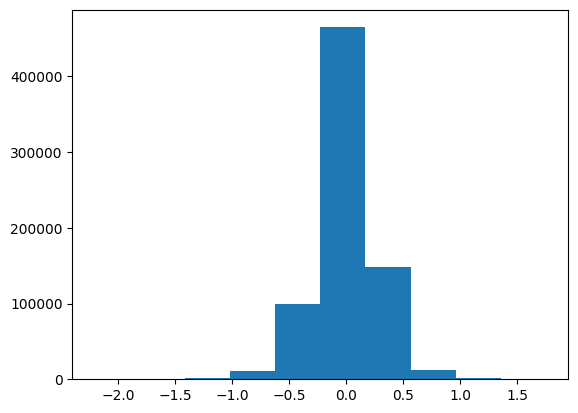

In [35]:
plt.hist(fts_subj_train[0]/5)

## CLIP

In [24]:
class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors, transform=None):
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[index]

#         if self.transform:
#             x = self.transform(x)

        return x

    def __len__(self):
        return self.tensors.shape[0]

train_dataset = CustomTensorDataset(ds_arr, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64)

In [25]:
import torch
from PIL import Image
import requests

from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# logits_per_image = outputs.logits_per_image # this is the image-text similarity score
# probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities

In [38]:

def clip_features(d):
    
    inputs = processor(text=["a photo of a cat", "a photo of a dog"], images=d, return_tensors="pt", padding=True)
    
    for key, value in inputs.items():
        inputs[key] = inputs[key].to(device)

    outputs = model(**inputs)
    return outputs['image_embeds'].detach().cpu().numpy()

def extract_features(dataloader):

    features = []
    for _, d in tqdm(enumerate(dataloader), total=len(dataloader)):
        
        print(d.shape)
        # Extract features
        ft = clip_features(d)
        # Flatten the features
        features.append(ft)
    return np.vstack(features)

In [33]:
features_train = extract_features(train_loader)


  0%|          | 0/1141 [00:00<?, ?it/s]

tensor([[[[162, 177, 172],
          [161, 175, 176],
          [159, 169, 179],
          ...,
          [151, 168, 176],
          [144, 164, 171],
          [151, 165, 166]],

         [[154, 173, 171],
          [169, 181, 181],
          [161, 175, 185],
          ...,
          [153, 164, 176],
          [143, 165, 174],
          [155, 174, 178]],

         [[161, 178, 168],
          [160, 176, 170],
          [154, 172, 178],
          ...,
          [151, 165, 175],
          [150, 165, 179],
          [156, 166, 175]],

         ...,

         [[191, 214, 222],
          [200, 218, 232],
          [201, 216, 232],
          ...,
          [225, 235, 243],
          [215, 234, 249],
          [223, 246, 252]],

         [[188, 215, 224],
          [192, 222, 233],
          [197, 226, 238],
          ...,
          [199, 230, 235],
          [212, 233, 238],
          [224, 244, 251]],

         [[191, 220, 228],
          [191, 223, 234],
          [189, 221, 232],
         

  0%|          | 0/1141 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [119]:
file_name = nsd_feats_dir + 'openai-clip-vit-base-patch32_512.npy'
features_train = np.load(file_name)

In [11]:
nsd_feats_dir = '../../../share/nklab/projects/nsd_features/'

#'detr_encoder_last_1000pc.npy'
#'detr_encoder_last_500pc.npy' 
# 'dinov2_vitb14_patch_features_last1_1000pc.npy'
#'dinov2_vitb14_q_features_last1_100pc.npy'

file_name = nsd_feats_dir + 'CLIP_ViT_L_14_336_features.npy'
features_train = np.load(file_name)

In [121]:
pca = PCA(n_components=50)
pca.fit(features_train)

PCA(n_components=50)

In [122]:
features_train_pca = pca.transform(features_train)

In [123]:
file_name = nsd_feats_dir + 'openai-clip-vit-base-patch32_50pc.npy'
np.save(file_name, features_train_pca)

In [9]:
features_pca[0]

array([ 3.13369147e-02,  4.46945392e-02,  1.53597696e-02, -1.49051193e-02,
        3.67578417e-02,  4.20614779e-02,  9.07251053e-03, -3.41922827e-02,
        4.21581045e-02,  7.98099581e-03, -1.36037543e-03, -4.07831371e-02,
        1.87325440e-02,  3.83571163e-02, -3.12291905e-02,  4.48935898e-03,
       -1.57416239e-02, -1.07952589e-02,  4.28928919e-02, -3.77885140e-02,
       -9.35867876e-02, -4.67771851e-02, -1.44485934e-02,  2.68457104e-02,
        2.87249479e-02,  6.21722192e-02,  8.40742048e-03,  5.07963598e-02,
       -1.23138418e-02,  1.89871714e-03, -4.41632718e-02,  2.80229356e-02,
        3.62683237e-02,  1.38974069e-02, -1.55962538e-03, -3.61796492e-03,
        2.82525085e-02, -3.09100021e-02,  4.25203936e-03,  1.15564503e-01,
        1.59260016e-02,  2.24354621e-02, -1.53426016e-02, -1.11231357e-02,
        1.21209603e-02, -9.26479250e-02,  4.64015752e-02, -8.44668411e-03,
       -3.40510309e-02,  2.24342961e-02, -4.51825075e-02, -2.66059823e-02,
       -2.36431491e-02, -

In [3]:
file_name = nsd_feats_dir + 'openai-clip-vit-base-patch32_512.npy'
features_pca = np.load(file_name)
features_pca.shape

(73000, 512)

In [8]:
for subj in range(1,9): #@param ["1", "2", "3", "4", "5", "6", "7", "8"] {type:"raw", allow-input: true}

    class argObj:
        def __init__(self, data_dir, parent_submission_dir, subj):

            self.subj = format(subj, '02')
            
            self.data_dir = os.path.join(data_dir, 'subj'+self.subj)
            self.parent_submission_dir = parent_submission_dir
            self.subject_submission_dir = os.path.join(self.parent_submission_dir,
                'subj'+self.subj)

            # Create the submission directory if not existing
            if not os.path.isdir(self.subject_submission_dir):
                os.makedirs(self.subject_submission_dir)

    args = argObj(data_dir, parent_submission_dir, subj)

    train_img_dir  = os.path.join(args.data_dir, 'training_split', 'training_images')
    #test_img_dir  = os.path.join(args.data_dir, 'test_split', 'test_images')
    
    test_img_dir = os.path.join(args.data_dir, '../nsdsynthetic_stimuli/')

    # Create lists will all training and test image file names, sorted
    train_img_list = os.listdir(train_img_dir)
    train_img_list.sort()
    test_img_list = os.listdir(test_img_dir)
    test_img_list.sort()
#     print('Training images: ' + str(len(train_img_list)))
#     print('Test images: ' + str(len(test_img_list)))

    train_imgs_paths = sorted(list(Path(train_img_dir).iterdir()))
    test_imgs_paths = sorted(list(Path(test_img_dir).iterdir()))

    idxs_train = np.arange(len(train_img_list))
    idxs_test = np.arange(len(test_img_list))

    fts_subj_train = []
    for i in range(len(train_imgs_paths)):

        ind = int(str(train_imgs_paths[i]).split('-')[-1].split('.')[0])
        fts_subj_train.append(features_pca[ind])

    fts_subj_train = np.vstack(fts_subj_train)

    fts_subj_test = []
    for i in range(len(test_imgs_paths)):

        ind = int(str(test_imgs_paths[i]).split('-')[-1].split('.')[0])
        fts_subj_test.append(features_pca[ind])

    features_test = np.vstack(fts_subj_test)
    
    feat_dir = './algonauts_image_features/clip_vit_512/' +  args.subj 
    
    if not os.path.isdir(feat_dir):
        os.makedirs(feat_dir)
        
    
    #np.save(feat_dir + '/train.npy', fts_subj_train)
    np.save(feat_dir + '/synt.npy', features_test)


### for image dataloaders

In [39]:
import os
import numpy as np
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import matplotlib
from matplotlib import pyplot as plt
from nilearn import datasets
from nilearn import plotting
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
from torchvision import transforms
from sklearn.decomposition import IncrementalPCA, PCA
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr as corr


data_dir = './algonauts_2023_challenge_data'
parent_submission_dir = './algonauts_2023_challenge_submission'

device = 'cuda' #@param ['cpu', 'cuda'] {allow-input: true}
device = torch.device(device)

for subj in range(1,9): #@param ["1", "2", "3", "4", "5", "6", "7", "8"] {type:"raw", allow-input: true}

    class argObj:
        def __init__(self, data_dir, parent_submission_dir, subj):

            self.subj = format(subj, '02')
            self.data_dir = os.path.join(data_dir, 'subj'+self.subj)
            self.parent_submission_dir = parent_submission_dir
            self.subject_submission_dir = os.path.join(self.parent_submission_dir,
                'subj'+self.subj)

            # Create the submission directory if not existing
            if not os.path.isdir(self.subject_submission_dir):
                os.makedirs(self.subject_submission_dir)



    args = argObj(data_dir, parent_submission_dir, subj)

    feature_dir = './algonauts_image_features'

    subject_feature_dir =  os.path.join(feature_dir, 'clip_vit_512',format(subj, '02'))

    if not os.path.isdir(subject_feature_dir):
        os.makedirs(subject_feature_dir)


    train_img_dir  = os.path.join(args.data_dir, 'training_split', 'training_images')
    #test_img_dir  = os.path.join(args.data_dir, 'test_split', 'test_images')

    test_img_dir = os.path.join(args.data_dir, '../nsdsynthetic_stimuli/')

    # Create lists will all training and test image file names, sorted
    train_img_list = os.listdir(train_img_dir)
    train_img_list.sort()
    test_img_list = os.listdir(test_img_dir)
    test_img_list.sort()
    print('Training images: ' + str(len(train_img_list)))
    print('Test images: ' + str(len(test_img_list)))

    idxs_train = np.arange(len(train_img_list))
    idxs_test = np.arange(len(test_img_list))

    transform = transforms.Compose([
        # transforms.Resize((224,224)), # resize the images to 224x24 pixels
        transforms.ToTensor(), # convert the images to a PyTorch tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalize the images color channels
    ])

    class ImageDataset(Dataset):
        def __init__(self, imgs_paths, idxs, transform):
            self.imgs_paths = np.array(imgs_paths)[idxs]
            self.transform = transform

        def __len__(self):
            return len(self.imgs_paths)

        def __getitem__(self, idx):
            # Load the image
            img_path = self.imgs_paths[idx]
            img = Image.open(img_path).convert('RGB')
            #img = img.resize()
            # Preprocess the image and send it to the chosen device ('cpu' or 'cuda')
    #         if self.transform:
    #             img = self.transform(img).to(device)
            return img


    batch_size = 200 #@param
    # Get the paths of all image files
    train_imgs_paths = sorted(list(Path(train_img_dir).iterdir()))
    test_imgs_paths = sorted(list(Path(test_img_dir).iterdir()))

    # The DataLoaders contain the ImageDataset class
    train_imgs_dataloader = DataLoader(
        ImageDataset(train_imgs_paths, idxs_train, transform), 
        batch_size=batch_size
    )

    test_imgs_dataloader = DataLoader(
        ImageDataset(test_imgs_paths, idxs_test, transform), 
        batch_size=batch_size
    )
    
    
    features_test = extract_features(test_imgs_dataloader)
    
    #np.save(subject_feature_dir + '/synt.npy', features_test)

Training images: 9841
Test images: 220



  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([200, 714, 714, 3])


  0%|          | 0/2 [00:05<?, ?it/s]


KeyboardInterrupt: 

In [10]:
features_test = extract_features(test_imgs_dataloader)

100%|██████████| 2/2 [00:25<00:00, 12.96s/it]


In [23]:
np.max(img)


NameError: name 'img' is not defined

In [16]:
subject_feature_dir + '/synt.npy'

'./algonauts_image_features/clip_vit_512/subj04/synt.npy'

## Sentence encoder 

In [66]:
nsd_stim_info =  '../../../share/nklab/projects/natural_scenes_dataset/nsddata/experiments/nsd/nsd_stim_info_merged.csv'

In [70]:
import pandas as pd 
df = pd.read_csv(nsd_stim_info)
df

,Unnamed: 0,cocoId,cocoSplit,cropBox,loss,nsdId,flagged,BOLD5000,shared1000,subject1,...,subject5_rep2,subject6_rep0,subject6_rep1,subject6_rep2,subject7_rep0,subject7_rep1,subject7_rep2,subject8_rep0,subject8_rep1,subject8_rep2
0,0,532481,val2017,"(0, 0, 0.1671875, 0.1671875)",0.100000,0,False,False,False,0,...,0,0,0,0,0,0,0,0,0,0
1,1,245764,val2017,"(0, 0, 0.125, 0.125)",0.000000,1,False,False,False,0,...,0,0,0,0,13985,14176,28603,0,0,0
2,2,385029,val2017,"(0, 0, 0.125, 0.125)",0.000000,2,False,False,False,0,...,0,0,0,0,0,0,0,0,0,0
3,3,311303,val2017,"(0, 0, 0.16640625, 0.16640625)",0.125000,3,False,False,False,0,...,0,0,0,0,0,0,0,0,0,0
4,4,393226,val2017,"(0, 0, 0.125, 0.125)",0.133333,4,False,False,False,0,...,0,13720,22861,23023,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72995,72995,518071,train2017,"(0, 0, 0.125, 0.125)",0.000000,72995,False,False,False,0,...,0,0,0,0,0,0,0,6083,11650,26531
72996,72996,255930,train2017,"(0, 0, 0.125, 0.125)",0.125000,72996,False,False,False,0,...,0,0,0,0,0,0,0,10402,10434,10625
72997,72997,255934,train2017,"(0, 0, 0.1, 0.1)",0.000000,72997,False,False,False,0,...,0,0,0,0,0,0,0,0,0,0
72998,72998,518080,train2017,"(0.125, 0.125, 0, 0)",0.000000,72998,False,False,False,0,...,0,0,0,0,5585,11846,14495,0,0,0


In [88]:
from sentence_transformers import SentenceTransformer
sentences = ["This is an example sentence", "Each sentence is converted"]

model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
embeddings = model.encode(sentences)
print(embeddings.shape)

(2, 768)


In [81]:

coco2017_path = '../coco'

annFile_train='{}/annotations/captions_{}.json'.format(coco2017_path,'train2017')
coco_train=COCO(annFile_train)

annFile_val='{}/annotations/captions_{}.json'.format(coco2017_path,'val2017')
coco_val=COCO(annFile_val)

loading annotations into memory...
Done (t=0.66s)
creating index...
index created!
loading annotations into memory...
Done (t=0.12s)
creating index...
index created!


In [96]:
sent_encs = []
for i in tqdm(range(len(df))):

    imgId = df['cocoId'].iloc[i]
    dataType = df['cocoSplit'].iloc[i]

    if dataType == 'train2017':
        annIds = coco_train.getAnnIds(imgIds=imgId)  #catIds=catIds, ,  iscrowd=None
        anns = coco_train.loadAnns(annIds)

    else:
        annIds = coco_val.getAnnIds(imgIds=imgId)  #catIds=catIds, ,  iscrowd=None
        anns = coco_val.loadAnns(annIds)

    capts = []
    for c in range(len(anns)):
        capts.append(anns[c]['caption'])
        
    encs = model.encode(capts)
        
    sent_encs.append(np.mean(encs, axis=0))

100%|██████████| 73000/73000 [13:21<00:00, 91.11it/s] 


In [97]:
features_train = np.vstack(sent_encs)

In [98]:
file_name = nsd_feats_dir + 'all-mpnet-base-v2_768.npy'
np.save(file_name, features_train)

In [111]:
pca = PCA(n_components=100)
pca.fit(features_train)

PCA(n_components=100)

In [112]:
features_train_pca = pca.transform(features_train)

In [113]:
file_name = nsd_feats_dir + 'all-mpnet-base-v2_100pc.npy'
np.save(file_name, features_train_pca)

In [ ]:
def fit_pca(feature_extractor, dataloader):

    # Define PCA parameters
    pca = IncrementalPCA(n_components=500, batch_size=batch_size)

    # Fit PCA to batch
    for _, d in tqdm(enumerate(dataloader), total=len(dataloader)):
        # Extract features
        ft = feature_extractor(d.to(device))
        
        
        # Flatten the features
        ft = torch.hstack([torch.flatten(l, start_dim=1) for l in ft.values()])
        # Fit PCA to batch
        pca.partial_fit(ft.detach().cpu().numpy())
    return pca

In [ ]:
def extract_features_pca(feature_extractor, dataloader, pca):

    features = []
    for _, d in tqdm(enumerate(dataloader), total=len(dataloader)):
        # Extract features
        ft = feature_extractor(d.to(device))
        # Flatten the features
        ft = torch.hstack([torch.flatten(l, start_dim=1) for l in ft.values()])
        # Apply PCA transform
        ft = pca.transform(ft.cpu().detach().numpy())
        features.append(ft)
    return np.vstack(features)